In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 27ms/step - loss: 2.6201 - val_loss: 0.4221
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.3808 - val_loss: 0.3401
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.2591 - val_loss: 0.3504
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2157 - val_loss: 0.3775
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.1827 - val_loss: 0.3933
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.1553 - val_loss: 0.3982
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.1241 - val_loss: 0.4137
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.1158 - val_loss: 0.4113
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.1028 - val_loss: 0.4232
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.0912 - val_loss: 0.4392
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.0857 - val_loss: 0.4123
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.0736 - val_loss: 0.4615
Epoch 12: early stopping
Epoch 1/1000
136/136 - 3s - 21ms/step - loss: 2.9649 - val_loss: 0.5413
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.

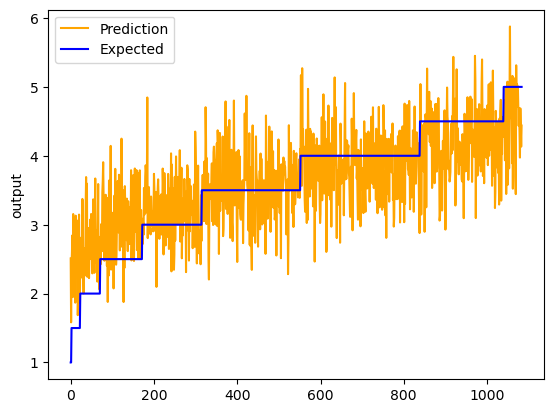

In [2]:
# Author: Nicolas Gugliemo, Katrina Yu
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 
# (1) Report the RMSE and plot the lift chart of the BEST neural network model you have obtained.
# (2) Choose 5 arbitrary businesses from your test data (preferably from different categories). Show
#     the names, the true star ratings, and the predicted ratings (from your best model) of those
#     businesses.
# Type: Regression (Expect a number)
# Data Restrictions:
# (1) Businesses with at least 20 reviews
# (2) At least 10K businesses in set
# (3) Business = busisness_id, stars, review_count, categories
# (4) Review   = busisness_id, stars, text 
'''Grading:  (5 pts) Do train/test split.
 (5 pts) Remove all the businesses with less than 20 reviews.
 (10 pts) Use TF-IDF to do feature extraction from review texts.
 (10 pts) Use EarlyStopping when using Tensorflow.
 (30 pts) Change the following hyperparameters to record how they affect performance in your report.
Tabulate your findings.
o Activation: relu, sigmoid, tanh
o Layers and neuron counts
o Optimizer: adam and sgd
 (10 pts) Report the RMSE of the BEST regression model you obtained
 (10 pts) Plot the lift chart on test data of the BEST regression model you obtained
 (5 pts) Show names and the true ratings of 5 businesses, and their predicted ratings
 (5 pts) Your report includes the following sections:
o Problem Statement
o Methodology
o Experimental Results and Analysis
o Task Division and Project Reflection
 (10 pts) Additional features
'''
import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i<10):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
print(pred)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 10 businesses
for j in range(10):
    #j = random.randint(0, (pred.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y[j], pred[j]))

print("{}. {} {}: rating: {}, predicted rating: {}".format(101+1, businesses[101], b_id[101], y[101], pred[101]))
j=1000
print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y[j], pred[j]))
# Plot the chart
chart_regression(pred.flatten(),y_test)

REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 10s - 76ms/step - loss: 3.0109 - val_loss: 0.4701
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.5866 - val_loss: 0.3524
Epoch 3/1000
136/136 - 1s - 10ms/step - loss: 0.4398 - val_loss: 0.3551
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.3802 - val_loss: 0.3695
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.3383 - val_loss: 0.4108
Epoch 6/1000
136/136 - 3s - 19ms/step - loss: 0.2967 - val_loss: 0.3925
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.2734 - val_loss: 0.4089
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.2728 - val_loss: 0.3990
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.2574 - val_loss: 0.3909
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.2310 - val_loss: 0.4035
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.2180 - val_loss: 0.3893
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.2124 - val_loss: 0.3928
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[3.1141293]
 [3.612523 ]
 [2.6019578]
 ...
 [4.7224026]
 [3.5804224]
 [

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 24ms/step - loss: 1.3009 - val_loss: 0.6483
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7633 - val_loss: 0.5785
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.7014 - val_loss: 0.5400
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.5939 - val_loss: 0.4509
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.5106 - val_loss: 0.4266
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.4501 - val_loss: 0.3809
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.4145 - val_loss: 0.3630
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3853 - val_loss: 0.3308
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.3655 - val_loss: 0.3048
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.3533 - val_loss: 0.3328
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.3343 - val_loss: 0.3003
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3359 - val_loss: 0.3065
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.3137 - val_loss: 0.2929
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.3064 - val_loss: 0.3014


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 59ms/step - loss: 2.0683 - val_loss: 0.4275
Epoch 2/1000
136/136 - 2s - 11ms/step - loss: 0.4350 - val_loss: 0.3741
Epoch 3/1000
136/136 - 2s - 11ms/step - loss: 0.3281 - val_loss: 0.3678
Epoch 4/1000
136/136 - 2s - 11ms/step - loss: 0.2874 - val_loss: 0.3812
Epoch 5/1000
136/136 - 1s - 11ms/step - loss: 0.2443 - val_loss: 0.4228
Epoch 6/1000
136/136 - 2s - 12ms/step - loss: 0.2302 - val_loss: 0.4003
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.2173 - val_loss: 0.4058
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.1911 - val_loss: 0.4160
Epoch 9/1000
136/136 - 1s - 10ms/step - loss: 0.1865 - val_loss: 0.3974
Epoch 10/1000
136/136 - 1s - 10ms/step - loss: 0.1781 - val_loss: 0.4247
Epoch 11/1000
136/136 - 2s - 11ms/step - loss: 0.1702 - val_loss: 0.3916
Epoch 12/1000
136/136 - 1s - 10ms/step - loss: 0.1590 - val_loss: 0.4038
Epoch 13/1000
136/136 - 1s - 10ms/step - loss: 0.1563 - val_loss: 0.4026
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 24ms/step - loss: 1.6389 - val_loss: 0.6287
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.7634 - val_loss: 0.5943
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.7071 - val_loss: 0.5559
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.6387 - val_loss: 0.4916
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.5676 - val_loss: 0.4257
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.4968 - val_loss: 0.3825
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.4378 - val_loss: 0.3402
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.4100 - val_loss: 0.3741
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3743 - val_loss: 0.3112
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.3598 - val_loss: 0.3145
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.3371 - val_loss: 0.3002
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.3326 - val_loss: 0.3003
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.3226 - val_loss: 0.3018
Epoch 14/1000
136/136 - 1s - 9ms/step - loss: 0.3092 - val_loss: 0.2975


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 60ms/step - loss: 2.0243 - val_loss: 0.3506
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.3327 - val_loss: 0.3389
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.2435 - val_loss: 0.3530
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.1945 - val_loss: 0.3708
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.1668 - val_loss: 0.3875
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.1470 - val_loss: 0.4080
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.1335 - val_loss: 0.4121
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.1180 - val_loss: 0.4186
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.1117 - val_loss: 0.4581
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.1044 - val_loss: 0.4099
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.0926 - val_loss: 0.4073
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.0924 - val_loss: 0.3927
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[3.1766708]
 [3.3209407]
 [2.6841753]
 ...
 [4.809317 ]
 [3.0592296]
 [4.08

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 12ms/step - loss: 1.4317 - val_loss: 0.6204
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7016 - val_loss: 0.5637
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.6412 - val_loss: 0.5118
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.5498 - val_loss: 0.4379
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.4779 - val_loss: 0.3723
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.4131 - val_loss: 0.3568
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.3856 - val_loss: 0.3454
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3494 - val_loss: 0.3169
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3419 - val_loss: 0.3353
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3239 - val_loss: 0.3020
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.3070 - val_loss: 0.3191
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.3031 - val_loss: 0.2995
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.2953 - val_loss: 0.3036
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.2784 - val_loss: 0.3377
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 23ms/step - loss: 4.9976 - val_loss: 1.0045
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.9853 - val_loss: 0.6616
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.8786 - val_loss: 0.6461
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.8843 - val_loss: 0.6462
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.8675 - val_loss: 0.6448
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.8572 - val_loss: 0.6446
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.8676 - val_loss: 0.6428
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.8599 - val_loss: 0.6424
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.8421 - val_loss: 0.6392
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.8313 - val_loss: 0.6323
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.8087 - val_loss: 0.6103
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.7692 - val_loss: 0.5277
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.6104 - val_loss: 0.3652
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.4774 - val_loss: 0.3149
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 16ms/step - loss: 1.1790 - val_loss: 0.6504
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7885 - val_loss: 0.6465
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.7606 - val_loss: 0.6470
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.7598 - val_loss: 0.6491
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.7528 - val_loss: 0.6481
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.7480 - val_loss: 0.6463
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.7494 - val_loss: 0.6486
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.7433 - val_loss: 0.6470
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.7520 - val_loss: 0.6459
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.7369 - val_loss: 0.6466
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.7391 - val_loss: 0.6505
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.7300 - val_loss: 0.6477
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[3.5966558]
 [3.5969415]
 [3.5964324]
 ...
 [3.5960567]
 [3.596879 ]
 [3.596593

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 5s - 34ms/step - loss: 1.6226 - val_loss: 0.6431
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.8208 - val_loss: 0.6388
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.8082 - val_loss: 0.6272
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.7842 - val_loss: 0.6009
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.6932 - val_loss: 0.4635
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.4870 - val_loss: 0.3324
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.3936 - val_loss: 0.3022
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.3590 - val_loss: 0.2922
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.3300 - val_loss: 0.2919
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.3171 - val_loss: 0.2917
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.2976 - val_loss: 0.2963
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.2807 - val_loss: 0.2931
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.2642 - val_loss: 0.2983
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2594 - val_loss: 0.3006


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 14ms/step - loss: 0.9855 - val_loss: 0.6467
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.8197 - val_loss: 0.6527
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.7756 - val_loss: 0.6512
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.7914 - val_loss: 0.6696
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.7775 - val_loss: 0.6528
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.7600 - val_loss: 0.6526
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.7501 - val_loss: 0.6618
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.7659 - val_loss: 0.6480
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.7392 - val_loss: 0.6566
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.7526 - val_loss: 0.6526
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.7461 - val_loss: 0.6536
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[3.5802243]
 [3.5796795]
 [3.5792549]
 ...
 [3.580553 ]
 [3.5801966]
 [3.58086  ]]
Score (RMSE): 0.8041642308235168


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 28ms/step - loss: 1.2976 - val_loss: 0.6353
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7384 - val_loss: 0.6193
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.6775 - val_loss: 0.5415
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.5079 - val_loss: 0.3492
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.3798 - val_loss: 0.3067
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.3276 - val_loss: 0.2924
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3000 - val_loss: 0.2915
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.2859 - val_loss: 0.2847
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2719 - val_loss: 0.2890
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.2548 - val_loss: 0.2889
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.2350 - val_loss: 0.2910
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2286 - val_loss: 0.2883
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.2174 - val_loss: 0.2952
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.2096 - val_loss: 0.2972


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 13ms/step - loss: 0.8444 - val_loss: 0.6459
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.7664 - val_loss: 0.6467
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.7512 - val_loss: 0.8489
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.7349 - val_loss: 0.6567
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.7371 - val_loss: 0.7244
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.7360 - val_loss: 0.6754
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.7290 - val_loss: 0.6920
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.7390 - val_loss: 0.6733
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.7311 - val_loss: 0.6575
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.7153 - val_loss: 0.6573
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.7172 - val_loss: 0.7524
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[3.6231167]
 [3.6238453]
 [3.6235356]
 ...
 [3.6231873]
 [3.6232202]
 [3.6235642]]
Score (RMSE): 0.8036569356918335
Epoch 1/1000


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 23ms/step - loss: 1.5555 - val_loss: 0.5093
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.4625 - val_loss: 0.2941
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.3566 - val_loss: 0.3038
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2970 - val_loss: 0.3265
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.2751 - val_loss: 0.3492
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.2407 - val_loss: 0.3624
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.2201 - val_loss: 0.3656
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.2054 - val_loss: 0.4057
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.1971 - val_loss: 0.3902
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.1738 - val_loss: 0.4011
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.1709 - val_loss: 0.4200
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.1605 - val_loss: 0.4442
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[2.615576 ]
 [3.649531 ]
 [2.4996266]
 ...
 [4.432157 ]
 [3.543514 ]
 [4.114665 ]]
Score (RM

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 13ms/step - loss: 1.0675 - val_loss: 0.6116
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7272 - val_loss: 0.5721
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.6587 - val_loss: 0.4907
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.5458 - val_loss: 0.3992
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.4454 - val_loss: 0.3511
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.4051 - val_loss: 0.3462
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.3683 - val_loss: 0.3746
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.3541 - val_loss: 0.3092
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.3352 - val_loss: 0.3239
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3147 - val_loss: 0.4448
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.3005 - val_loss: 0.5050
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3021 - val_loss: 0.3021
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.2849 - val_loss: 0.3319
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.2794 - val_loss: 0.4541


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 29ms/step - loss: 1.3106 - val_loss: 0.3330
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.3834 - val_loss: 0.3074
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.3007 - val_loss: 0.3247
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.2541 - val_loss: 0.3393
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.2286 - val_loss: 0.3373
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.2066 - val_loss: 0.3637
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.1903 - val_loss: 0.3883
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.1797 - val_loss: 0.3902
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.1718 - val_loss: 0.3989
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.1610 - val_loss: 0.4377
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.1523 - val_loss: 0.4120
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.1413 - val_loss: 0.4236
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[2.2747347]
 [3.4704978]
 [2.7989142]
 ...
 [4.204968 ]
 [3.4745133]
 [3.95677

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 14ms/step - loss: 1.0081 - val_loss: 0.6067
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.6823 - val_loss: 0.5356
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.5964 - val_loss: 0.4522
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.4688 - val_loss: 0.3751
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.4020 - val_loss: 0.4923
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.3699 - val_loss: 0.4283
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3527 - val_loss: 0.3238
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.3368 - val_loss: 0.3732
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3245 - val_loss: 0.3069
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.3072 - val_loss: 0.3003
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.2909 - val_loss: 0.3207
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2899 - val_loss: 0.3659
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.2791 - val_loss: 0.4404
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.2733 - val_loss: 0.3061
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 24ms/step - loss: 1.3724 - val_loss: 0.3353
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.3042 - val_loss: 0.3211
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.2385 - val_loss: 0.3523
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2044 - val_loss: 0.3614
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.1788 - val_loss: 0.3853
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.1644 - val_loss: 0.4037
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.1451 - val_loss: 0.4089
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.1322 - val_loss: 0.4316
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.1196 - val_loss: 0.4808
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.1145 - val_loss: 0.4320
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.1105 - val_loss: 0.4608
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.0971 - val_loss: 0.4570
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[2.9424489]
 [3.3560398]
 [2.489437 ]
 ...
 [4.305034 ]
 [3.7269084]
 [3.95246  ]]
Score (RM

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 11ms/step - loss: 1.0043 - val_loss: 0.6039
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.6278 - val_loss: 0.5160
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.5334 - val_loss: 0.4394
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.4336 - val_loss: 0.3574
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.3677 - val_loss: 0.3234
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.3361 - val_loss: 0.3586
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.3195 - val_loss: 0.3354
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3062 - val_loss: 0.4047
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.3024 - val_loss: 0.3572
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.2848 - val_loss: 0.3425
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.2716 - val_loss: 0.3678
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2683 - val_loss: 0.2962
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.2573 - val_loss: 0.2981
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.2552 - val_loss: 0.3021
Epoch 15/1000

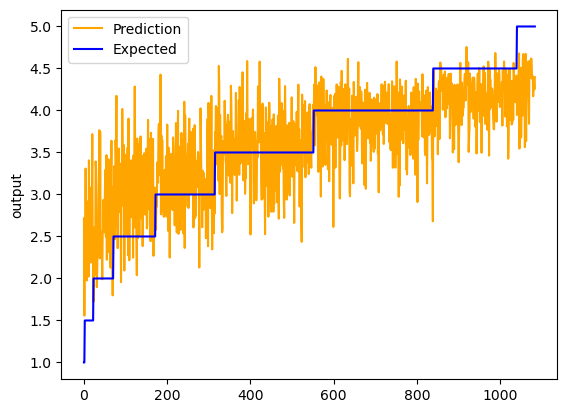

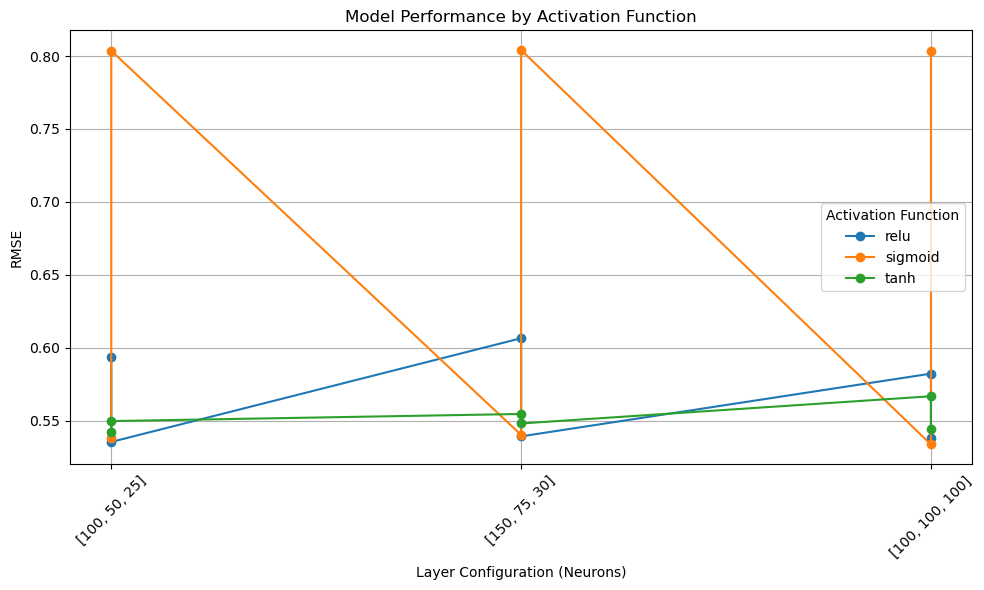

In [4]:
''' 
Tuning the following hyperparameters when training neural networks using Tensorflow and
tabulate all the results of each model on how they affect performance in your report. Also,
save all the models you have tried as a proof in your notebook.
• Activation: relu, sigmoid, tanh
• Number of layers and neuron count for each layer
• Optimizer: adam and sgd. 
'''

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set path and preprocess for functions
path = "./yelp_dataset/"

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define hyperparameters that were requested
activations = ['relu', 'sigmoid', 'tanh']
layer_neurons = [[100, 50, 25], [150, 75, 30], [100, 100, 100]]  # Different layer configurations
optimizers = ['adam', 'sgd']

def Model_Test(activation, layer_neurons, optimizer):
    model = Sequential()
    model.add(Dense(layer_neurons[0], input_dim=x_train.shape[1], activation=activation))
    model.add(Dropout(0.1))
    for n in layer_neurons[1:]:
        model.add(Dense(n, activation=activation))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

best_rmse = float('inf')
best_model = None
best_params = {}

results = []

for activation in activations:
    for neurons in layer_neurons:
        for optimizer in optimizers:
            model = Model_Test(activation, neurons, optimizer)

            #
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
            model_filename = f"model_{activation}_{neurons}_{optimizer}.keras"
            checkpointer = ModelCheckpoint(filepath=model_filename, verbose=0, save_best_only=True) # save best model

            # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
            model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

            #
            model.load_weights(model_filename)

            # Predict and measure RMSE
            pred = model.predict(x_test)
            print(pred)
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print("Score (RMSE): {}".format(score))

            # Store results
            results.append({
                'Activation': activation,
                'Neurons': str(neurons),
                'Optimizer': optimizer,
                'RMSE': score
            })

            if score < best_rmse:
                best_rmse = score
                best_model = model
                best_params = {
                    'Activation': activation,
                    'Neurons': neurons,
                    'Optimizer': optimizer,
                    'RMSE': best_rmse
                }

# Table of Results
results_df = pd.DataFrame(results)
print(results_df)

print("\nBest Combination:")
print(best_params)

# Plot the chart
pred = best_model.predict(x_test)
chart_regression(pred.flatten(), y_test)

plot(results_df)